# Day 11 - Retro

Source
- London shapefiles via [London Datastore](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)
- TfL station data [via API](https://api-portal.tfl.gov.uk/api-details#api=stationdata&operation=detailed)

## Setup

In [3]:
import pandas as pd

import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

In [4]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

In [5]:
_crs = 'EPSG:32630'

### London boroughs

In [7]:
#load london boroughs
london = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\London_Borough_Excluding_MHW.shp'))
london = london.to_crs('EPSG:4326')

### Tfl station data

In [8]:
# load stations
stations = pd. read_csv(os.path.join(project_root, 'TfL station data detailed\\Stations.csv'))
stations = stations.rename(columns={'UniqueId': 'StationUniqueId' })

# load station points
stationp = pd. read_csv(os.path.join(project_root, 'TfL station data detailed\\StationPoints.csv'))
stationp = stationp[stationp['FriendlyName']!='Bus']

# load platforms
platforms = pd. read_csv(os.path.join(project_root, 'TfL station data detailed\\Platforms.csv'))
platforms = platforms.rename(columns={'UniqueId': 'PlatformUniqueId'})

# load platform services
platformser = pd. read_csv(os.path.join(project_root, 'TfL station data detailed\\PlatformServices.csv'))

In [9]:
# merge station + station points for lat/lon
df = pd.merge(stations[['StationUniqueId', 'Name', 'FareZones']],
              stationp[['StationUniqueId', 'AreaName', 'AreaId', 'Lat','Lon']], 
              on='StationUniqueId', how='left')

# merge with platforms
df = pd.merge(df, platforms[['PlatformUniqueId', 'StationUniqueId']],
                on='StationUniqueId', how='left' )

# merge with platform services for line
df = pd.merge(df, platformser[['PlatformUniqueId', 'Line']], 
                on='PlatformUniqueId', how='left' )
df.head()

,StationUniqueId,Name,FareZones,AreaName,AreaId,Lat,Lon,PlatformUniqueId,Line
0,HUBABW,Abbey Wood,4,EL EB,8,51.49128,0.12109,HUBABW-Plat01-WB-national-rail,national-rail
1,HUBABW,Abbey Wood,4,EL EB,8,51.49128,0.12109,HUBABW-Plat02-EB-national-rail,national-rail
2,HUBABW,Abbey Wood,4,EL EB,8,51.49128,0.12109,HUBABW-Plat03-WB-elizabeth,elizabeth
3,HUBABW,Abbey Wood,4,EL EB,8,51.49128,0.12109,HUBABW-Plat04-WB-elizabeth,elizabeth
4,HUBABW,Abbey Wood,4,EL WB,9,51.49122,0.12108,HUBABW-Plat01-WB-national-rail,national-rail


In [10]:
# filter for underground + overground
df = df[~df['Line'].isin(['national-rail', 'thameslink', 'tram', 'london-cable-car'])]

# get single coords per station
coords = df.drop_duplicates(subset=['StationUniqueId'], keep='first')[['StationUniqueId', 'Lat', 'Lon']]

# drop duplicate (ie. platform info)
df = df.drop_duplicates(subset=['StationUniqueId', 'Name', 'FareZones','Line'], keep='first')[['StationUniqueId', 'Name', 'FareZones', 'Line']]

# merge coords back
df = pd.merge(df, coords, on='StationUniqueId')

# Data processing

In [11]:
# convert tfl data into geodataframe
geometry = [Point(xy) for xy in zip(df['Lon'].astype(float), df['Lat'].astype(float))]
df_geo = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [12]:
moquettes = {'district': 'dis cir ham met', 
             'circle':  'dis cir ham met',
             'hammersmith-city': 'dis cir ham met',
             'metropolitan':'dis cir ham met',
             'london-overground': 'overground',
             'elizabeth': 'elizabeth',
             'jubilee': 'north cent jub',
             'piccadilly': 'piccadilly',
             'central': 'north cent jub',
             'victoria': 'victoria',
             'northern': 'north cent jub',
             'bakerloo': 'bakerloo',
             'dlr': 'dlr',
             'waterloo-city': 'waterloo-city'
}

In [13]:
# merge with london boroughs
merged = gpd.sjoin(london, df_geo, how='left')
merged['moquettes'] = merged['Line'].map(moquettes)

# find majority moquette pattern per borough
majority = merged[['NAME', 'moquettes']].value_counts().to_frame().reset_index()
majority = pd.pivot(majority, index='NAME', columns='moquettes', values='count')
majority['max']= majority.idxmax(axis=1)
majority = majority.reset_index()
majority

moquettes,NAME,bakerloo,dis cir ham met,dlr,elizabeth,north cent jub,overground,piccadilly,victoria,waterloo-city,max
0,Barking and Dagenham,NaN,6.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,dis cir ham met
1,Barnet,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,north cent jub
2,Brent,10.0,4.0,NaN,NaN,7.0,12.0,2.0,NaN,NaN,overground
3,Bromley,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,overground
4,Camden,NaN,7.0,NaN,1.0,17.0,9.0,3.0,3.0,NaN,north cent jub
5,City of London,NaN,17.0,2.0,1.0,5.0,1.0,NaN,NaN,1.0,dis cir ham met
6,Croydon,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,overground
7,Ealing,NaN,4.0,NaN,5.0,7.0,2.0,6.0,NaN,NaN,north cent jub
8,Enfield,NaN,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,overground
9,Greenwich,NaN,NaN,3.0,2.0,1.0,NaN,NaN,NaN,NaN,dlr


In [165]:
# merge majority into london boroughs
london = pd.merge(london, majority[['NAME', 'max']], on='NAME', how='left')
london['max'] = london['max'].fillna('None')

## Visualisation

Finalised in Figma

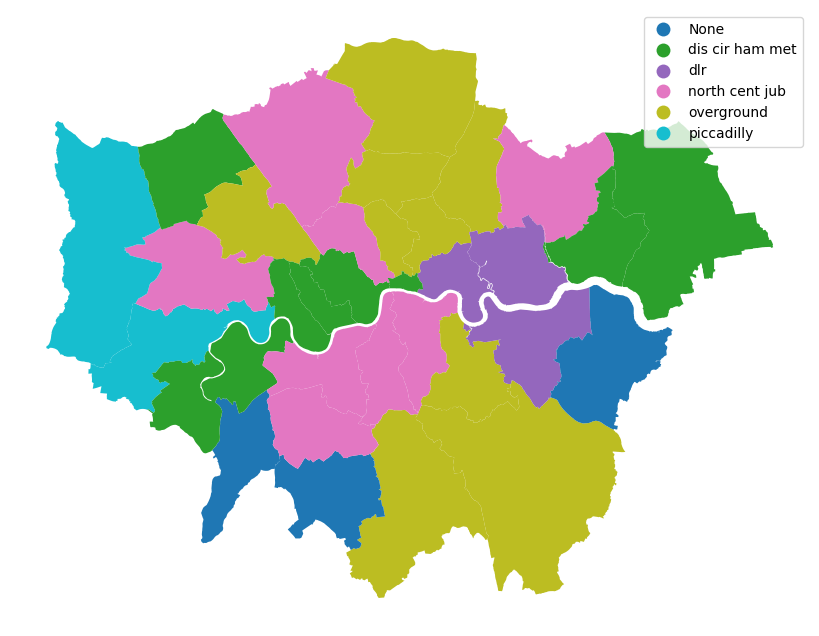

In [166]:
fig, ax = plt.subplots(figsize=(12,8))
london.plot(ax=ax, column='max', legend=True)
ax.axis('off')

# save as svg
plt.savefig('moquettes-by-borough.svg', transparent=True)

plt.show()

## Playground

### OSM data

In [4]:
import requests
import json
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
# get stations from OSM using Overpass API
overpass_url = 'http://overpass-api.de/api/interpreter'
overpass_query = '''
[out:json];
area[name='Greater London'][admin_level=5]->.searchArea;

(node['railway'='station'](area.searchArea);   
);
out center;

'''
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [5]:
#convert json into dataframe
df_dict = {'id':[], 'type': [], 'lat':[], 'lon': [],'name':[], 'line':[], 'operator':[]}

for element in data['elements']:
    df_dict['id'].append(element['id'])
    df_dict['type'].append(element['type'])
    
    for tag in list(df_dict.keys())[4:]:
        try:
            df_dict[tag].append(element['tags'][tag])
        except KeyError:
            df_dict[tag].append('') 
    if element['type']=='node':
        df_dict['lat'].append(element['lat'])
        df_dict['lon'].append(element['lon'])
    else:
        df_dict['lat'].append(element['center']['lat'])
        df_dict['lon'].append(element['center']['lon'])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [7]:
gdf.to_csv('london-tube-stations.csv')